In [1]:
import pickle
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import loess
import pandas as pd
from scipy import stats
from scipy.special import erf
from matplotlib import patches as mpatches
from matplotlib.patches import Rectangle, FancyBboxPatch
import common_functions as cf
from common_functions import *


In [2]:
# This notebook generates Figures S9 and S10, which depict the distributions of fixed effect sizes


In [3]:
# This file stores the summarized version of simulation results
with open("/burg-archive/palab/users/wm2377/snakemake_versions/Figure6and8/sdist_expon/simulations_summary_all.pickle",'rb') as f:
    simulations_summary = pickle.load(f)

'''
The relevant struture of simulations_summary is as follows:
{N2U: sigma2: shift: {type: {adaptation: x, number: y}}}
This gives the adaptation from large effect alleles that fix and the number of such alleles for each simulation replicate.
"type" refers to whether we consider all fixations or only the first fixations.
For these graphs, we only consider "first fixations".
We approximate the effect size of fixed alleles as 2a=adaptation if number=1 and ignore replicates where no alleles fix.
This implicitly assumes 1-x_0 is approximately 1, where x_0 is the initial frequency of the large effect allele. This assumption is reasonable for large effect alleles.
'''


'\nThe relevant struture of simulations_summary is as follows:\n{N2U: sigma2: shift: {type: {adaptation: x, number: y}}}\nThis gives the adaptation from large effect alleles that fix and the number of such alleles for each simulation replicate.\n"type" refers to whether we consider all fixations or only the first fixations.\nFor these graphs, we only consider "first fixations".\nWe approximate the effect size of fixed alleles as 2a=adaptation if number=1 and ignore replicates where no alleles fix.\nThis implicitly assumes 1-x_0 is approximately 1, where x_0 is the initial frequency of the large effect allele. This assumption is reasonable for large effect alleles.\n'

In [4]:
# This file stores the summarized version of analytical results
with open('/burg-archive/palab/users/wm2377/snakemake_versions/Figure6and8/sdist_expon/analytics_summary_all.pickle', 'rb') as f:
    analytics_summary = pickle.load(f)


In [5]:
def make_figure_S9(fig_height,fig_width):
    fontsize=12
    fig,axes = plt.subplots(figsize=(fig_width,fig_height),dpi=300,ncols=3,nrows=1)
    chosen_N2U = [0.01]
    sdist = stats.expon(scale=400,loc=100)

    # Store average effect sizes for later use
    average_effect_size = {}

    for N2U in simulations_summary.keys():
        # Find the correct 2NU values to plot and assign them a color
        keep = False
        for cN2U in chosen_N2U:
            if np.isclose(N2U, cN2U):
                keep = True
                chosen_N2U_temp = cN2U
                if N2U == 0.01:
                    color = 'r'
                else:
                    color = 'orange'
                label = r'$2NU=$'+f'{cN2U}'
                
        if not keep:
            continue
        
        
        for sigma2 in simulations_summary[N2U].keys():
                
            for shift in simulations_summary[N2U][sigma2].keys():
                
                # Select the correct subplot and letter label
                if shift == 80 and sigma2 == 40:
                    ax = axes[1]
                    letter = r'$\bf{B.}$'
                elif shift == 80 and sigma2 == 80:
                    ax = axes[0]
                    letter = r'$\bf{A.}$'
                elif shift == 50 and sigma2 == 80:
                    ax = axes[2]
                    letter = r'$\bf{C.}$'
                else:
                    continue
                
                for typee in simulations_summary[N2U][sigma2][shift].keys():
                    # Only consider first fixations
                    if typee == 'fixations': continue
                    
                    # Get the analytic prediction of the cdf
                    x_values = np.array(list(analytics_summary[sigma2][shift]['dfe'].keys()))
                    y_values = np.array([analytics_summary[sigma2][shift]['dfe'][x] for x in x_values])
                    yz_values = y_values/sum(y_values)*100
                    xx_values = sdist.ppf(x_values)
                    # plot a running sum of y vs x
                    p0, = ax.plot(list(sdist.ppf(x_values))+[3000],[sum(y_values[:i])/sum(y_values) for i in range(len(y_values))]+[1],color='k',lw=2,label='Analytic prediction')
                    
                    # store these results for later use
                    average_effect_size[(sigma2, shift)] = (xx_values, yz_values)
                    # plot the distribution of effect sizes for new alleles
                    ax.plot(sdist.ppf(np.linspace(0,1,1000)),np.linspace(0,1,1000),color='grey',lw=2)
                        
                    # Get the effect sizes from simulations and transform to effect size squared
                    effect_size = (np.array(simulations_summary[N2U][sigma2][shift][typee]['adaptation'])/2)**2
                    # Remove zeros, which correspond to no fixations
                    effect_size_fixed = effect_size[effect_size > 0]
                    # Plot the empirical cdf from simulations
                    cdf_y = np.linspace(0,1,len(effect_size_fixed))
                    cdf_x = np.sort(effect_size_fixed)
                    ax.plot(cdf_x,cdf_y,color=color,ls='--',zorder=100,lw=2)
                    
                    # Add error shading via bootstrapping
                    square_sum_values = np.zeros_like(cdf_x)
                    sum_values = np.zeros_like(cdf_x)
                    bootstrap_samples = 10
                    for i in range(bootstrap_samples):
                        effect_size_fixed_bootstrap = np.random.choice(effect_size_fixed, size=effect_size_fixed.shape[0], replace=True)
                        sum_values += np.sort(effect_size_fixed_bootstrap)
                        square_sum_values += np.sort(effect_size_fixed_bootstrap**2)
                    err_values = square_sum_values/ bootstrap_samples - (sum_values/ bootstrap_samples)**2
                    err_values = np.sqrt(err_values / bootstrap_samples)
                    ax.fill_betweenx(y=cdf_y, x1 = cdf_x - err_values, x2 = cdf_x + err_values, alpha=0.2,color=color,zorder=100)
                    
                    # Add title
                    ax.set_title(letter+r'$\Lambda=$'+f'{shift}, '+r'$\sigma^2=$'+f'{sigma2}', fontsize=fontsize,loc='left',pad=0)
                    
    # Format axes
    for ax in axes.flatten():
        ax.set_xscale('log')
        ax.set_ylim(0, 1)
        ax.set_xlim([100,3000])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_yticks([0,0.5,1])
        ax.set_yticklabels(['0',r'$\frac{1}{2}$','1'],fontsize=fontsize)
        ax.set_xlabel('Effect size squared'+'\n'+r'($S=a^2$)',fontsize=fontsize,labelpad=0)

    # Add common labels and legend
    axes[0].set_ylabel('CDF value',fontsize=fontsize,labelpad=-1)

    legend_entries = {}
    p0, = axes[0].plot([],[],color='r',ls='--',lw=2)
    p1 = mpatches.Patch(color='r',alpha=0.2)
    legend_entries[r'$2NU=0.01$'] = (p0,p1)

    p4, = axes[0].plot([],[],color='k',ls='-',lw=2)
    legend_entries[r'$g_f(a)$'] = p4

    p5, = axes[0].plot([],[],color='grey',ls='-',lw=2)
    legend_entries[r'$g(a)$'] = p5

    axes[0].legend(legend_entries.values(),legend_entries.keys(),edgecolor='k',loc = (0.5,-0.7),handlelength = 1, ncols=3,fontsize=fontsize)

    # Add background boxes and labels
    first_box_initial = (0.06,-0.25)
    first_box_size = (0.58,1.35)
    second_box_initial = (first_box_initial[0]+first_box_size[0],first_box_initial[1])
    second_box_size = (0.92-(first_box_initial[0]+first_box_size[0]),first_box_size[1])

    fig.patches.extend([FancyBboxPatch(first_box_initial,first_box_size[0],first_box_size[1], boxstyle='Round, pad=0,rounding_size=0.05', mutation_aspect=2,facecolor=cf.colorA_face,edgecolor=cf.colorA_edge,clip_on=False,transform=fig.transFigure, figure=fig,zorder=-1)])
    fig.patches.extend([FancyBboxPatch(second_box_initial,second_box_size[0],second_box_size[1], boxstyle='Round, pad=0,rounding_size=0.05', mutation_aspect=2,facecolor=cf.colorB_face,edgecolor=cf.colorB_edge,clip_on=False,transform=fig.transFigure, figure=fig,zorder=-1)])
    fig.text(x=(first_box_initial[0]*2+first_box_size[0])/2,y=first_box_size[1]+first_box_initial[1]-0.1,s=r'$\bf{Permissive}$',color=cf.colorA/2,fontsize=fontsize,ha='center')
    fig.text(x=(second_box_initial[0]*2+second_box_size[0])/2,y=second_box_size[1]+second_box_initial[1]-0.1,s=r'$\bf{Restrictive}$',color=cf.colorB/2,fontsize=fontsize,ha='center')

    bbox = axes[0].get_window_extent()
    # Convert the bounding box to inches using the figure's DPI
    width_inches = bbox.width / fig.dpi
    height_inches = bbox.height / fig.dpi
    return fig, fig_width, fig_height, width_inches, height_inches


Adjusting figure width from 7.30 to 7.56 inches to achieve target width of 6.50 inches.


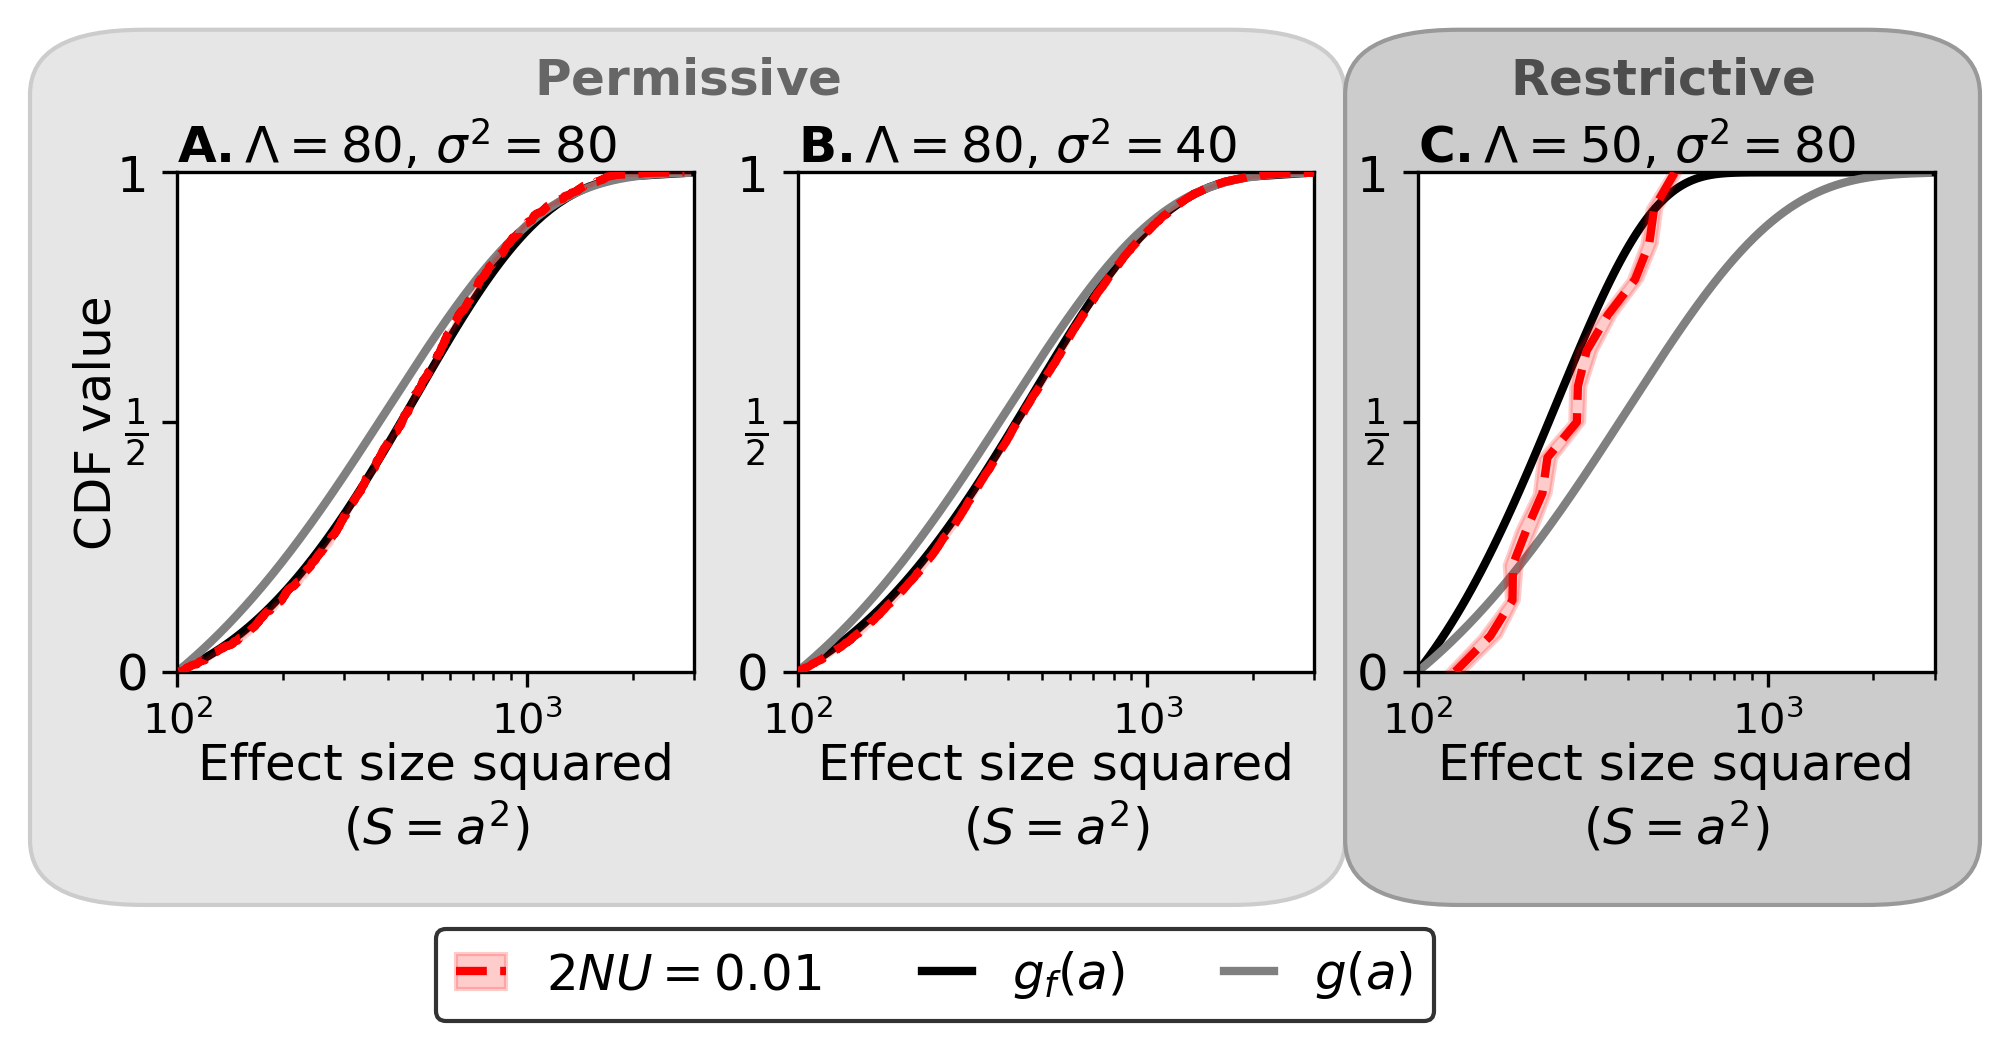

In [6]:
cf.make_figure_set_width(fig_function=make_figure_S9,filename='./Figures/Figure_S9.png', target_width_inches=6.5, fig_width=7.3, fig_height=3)


In [7]:
def make_figure_S10(fig_height,fig_width):

    fig = plt.figure(figsize=(fig_width,fig_height),dpi=400)

    # Set up axes
    mini_plot_width = 0
    spacing = 0.02
    width = (1-mini_plot_width-spacing*3)/3
    ax_C = fig.add_axes([mini_plot_width+spacing, 0.05, width, 0.9])
    ax_D = fig.add_axes([mini_plot_width+width+spacing*2, 0.05, width, 0.9])
    ax_E = fig.add_axes([mini_plot_width+width*2+spacing*3, 0.05, width, 0.9])
    fontsize = 12

    # Dictionary to access axes
    axd = {'C':ax_C,
        'D':ax_D,
        'E':ax_E}

    # Which 2NU values to plot and the assumed distribution of effect sizes for new alleles
    chosen_N2U = [0.01, 0.1, 1, 10, 100, 1000]
    sdist = stats.expon(scale=400,loc=100)

    # Store average effect sizes for later use
    average_effect_size = {}
    for N2U in simulations_summary.keys():
        keep = False
        for cN2U in chosen_N2U:
            if np.isclose(N2U, cN2U):
                keep = True
                
        if not keep: continue
        
        for sigma2 in simulations_summary[N2U].keys():

            for shift in simulations_summary[N2U][sigma2].keys():
        
                for typee in simulations_summary[N2U][sigma2][shift].keys():
                    
                    if typee == 'fixations': 
                        continue
                    
                    if N2U < 0.02:
                        x_values = np.array(list(analytics_summary[sigma2][shift]['dfe'].keys()))
                        y_values = np.array([analytics_summary[sigma2][shift]['dfe'][x] for x in x_values])
                        average_effect_size[(sigma2, shift)] = (x_values, y_values)
                        
    data = {} 
    # Collect effect sizes from simulations        
    for N2U in np.sort(list(simulations_summary.keys())):
        for sigma2 in simulations_summary[N2U].keys():
            for shift in simulations_summary[N2U][sigma2].keys():
                
                if (sigma2,shift) not in data.keys():
                    data[(sigma2,shift)] = {}
                
                for typee in simulations_summary[N2U][sigma2][shift].keys():
                    
                    if typee == 'fixations': 
                        continue
                    
                    effect_size = (np.array(simulations_summary[N2U][sigma2][shift][typee]['adaptation'])/2)**2
                    effect_size_fixed = effect_size[effect_size > 0]
                    if len(effect_size_fixed)> 5:
                        data[(sigma2,shift)][N2U] = effect_size_fixed
                    
    # Plot boxplots of effect sizes from simulations 
    for sigma2 in simulations_summary[N2U].keys():
        for shift in simulations_summary[N2U][sigma2].keys():
            
            if shift == 80 and sigma2 == 40:
                color = 'purple'
                shift_x = 1
                ax = axd['C']
            elif shift == 80 and sigma2 == 80:
                color = 'cornflowerblue'
                shift_x = 1
                ax = axd['D']
            elif shift == 50 and sigma2 == 80:
                color = 'lightcoral'
                shift_x = 1
                ax = axd['E']
            else:
                continue      
            
            bplot = ax.boxplot(data[(sigma2,shift)].values(),sym='',whis=(2.5,97.5),patch_artist=True,
                            showmeans=True, 
                            meanline = True,
                            positions = [N2U*shift_x for N2U in data[(sigma2,shift)].keys()],
                            widths = [N2U/4 for N2U in data[(sigma2,shift)].keys()])
            
            # Customize boxplot appearance
            for patch, patch_color in zip(bplot['boxes'], [color]*len(bplot['boxes'])):
                patch_color_temp = np.array(mpl.colors.to_rgba(color))
                
                patch_color_temp[-1] = 0.3
                patch.set_facecolor(patch_color_temp)
                patch.set_edgecolor([0.7]*3)
                
            for mline in bplot['medians']:
                mline.set_color('k')
                mline.set_linewidth(2)
                
            for mline in bplot['means']:
                mline.set_color('w')
                mline.set_linewidth(2)
        
        
    # Plot analytic predictions as boxplots for a tiny 2NU (no interference)
    for (sigma2,shift) in average_effect_size.keys():
        x_,y_ = average_effect_size[(sigma2, shift)]

        item = {}

        item["label"] = 'box' # not required
        item["mean"] = sum([sdist.ppf(xx)*yy for xx,yy in zip(x_,y_)])/sum([yy for xx,yy in zip(x_,y_)]) # not required
        
        total_sum = sum([yy for xx,yy in zip(x_,y_)])
        running_sum = 0
        for xx,yy in zip(x_,y_):
            running_sum += yy/total_sum
            for value,key in zip([0.025,0.25,0.5,0.75,0.975],['whislo','q1','med','q3','whishi']):
                if running_sum > value and key not in item:
                    item[key] = sdist.ppf(xx)
        
        # Create boxplot
        statsg = [item]
        if shift == 80 and sigma2 == 40:
            position = 0.7
            color = 'grey'
            ax_key = 'C'
        elif shift == 80 and sigma2 == 80:
            position = 1.4
            color = 'grey'
            ax_key = 'D'
        elif shift == 50 and sigma2 == 80:
            position = 2.1
            color = 'grey'
            ax_key = 'E'
        else:
            continue
        
        bplot = axd[ax_key].bxp(statsg,positions=[10**(-3.2)],showfliers=False,patch_artist=True,
                            showmeans=True, 
                            meanline = True,
                            widths = 10**(-3.2)/4)
            
        # Customize boxplot appearance
        for patch, patch_color in zip(bplot['boxes'], [color]*len(bplot['boxes'])):
            patch_color_temp = np.array(mpl.colors.to_rgba('grey'))
            patch_color_temp[-1] = 0.5
            patch.set_facecolor(patch_color_temp)
            
        for mline in bplot['medians']:
            mline.set_color('k')
            mline.set_linewidth(2)
            
        for mline in bplot['means']:
            mline.set_color('w')
            mline.set_linewidth(2)
        
    # Format axes
    for ax_key in axd.keys():
        
        axd[ax_key].set_yscale('log')
        axd[ax_key].set_ylim([100,2500])
        if ax_key == 'C':
            axd[ax_key].set_ylabel(r'Effect size squared ($S=a^2$)',fontsize=fontsize,labelpad=0)
            g = axd[ax_key].get_yticklabels()
            axd[ax_key].set_yticklabels([gg for gg in g],fontsize=fontsize)
        else:
            g = axd[ax_key].get_yticks()
            axd[ax_key].set_yticklabels(['' for gg in g])
        axd[ax_key].set_xscale('log')
        axd[ax_key].set_xlim([10**(-3.2)/1.3,200*1.2])
        axd[ax_key].set_xlabel(r'Mutational input ($2NU$)',fontsize=fontsize,labelpad=0)
        axd[ax_key].set_xticks([1e-3,1e-2,1e-1,1,1e1,1e2])
        axd[ax_key].set_xticklabels(['',r'$10^{-2}$','',r'$1$','',r'$10^2$'],fontsize=fontsize)
        axd[ax_key].tick_params(bottom=False,which='minor')
        
    # Add titles
    axd['C'].set_title(r'$\bf{A.}$'+r'$\Lambda = 80, \sigma^2 = 40$',fontsize=fontsize,loc='left')
    axd['D'].set_title(r'$\bf{B.}$'+r'$\Lambda = 80, \sigma^2 = 80$',fontsize=fontsize,loc='left')
    axd['E'].set_title(r'$\bf{C.}$'+r'$\Lambda = 50, \sigma^2 = 80$',fontsize=fontsize,loc='left')

    # Add arrow and label for gf(a)
    from matplotlib.patches import FancyArrowPatch
    # Define arrow properties
    tail_position = (10**(-2.2), 2100)
    head_position = (10**(-3.2), 1600)
    arrow_style = "Simple, tail_width=0.5, head_width=5, head_length=8"
    connection_style = "arc3,rad=.5" # Adjust 'rad' for different curvature

    arrow_properties = {
        "arrowstyle": arrow_style,
        "color": "k",
    }

    # Create the FancyArrowPatch
    arrow = FancyArrowPatch(
        tail_position,
        head_position,
        connectionstyle=connection_style,
        **arrow_properties
    )

    # Add the arrow to the axes
    axd['C'].add_patch(arrow)

    axd['C'].text(x = 10**(-2.2), y = 2000, s = r'$g_f(a)$',fontsize=fontsize,color='k')

    # add background boxes and labels
    first_box_initial = (-0.072,-0.16)
    first_box_size = (0.75,1.34)
    second_box_initial = (first_box_initial[0]+first_box_size[0],first_box_initial[1])
    second_box_size = (1.01-(first_box_initial[0]+first_box_size[0]),first_box_size[1])

    fig.patches.extend([FancyBboxPatch(first_box_initial,first_box_size[0],first_box_size[1], boxstyle='Round, pad=0,rounding_size=0.05', mutation_aspect=2,facecolor=cf.colorA_face,edgecolor=cf.colorA_edge,clip_on=False,transform=fig.transFigure, figure=fig,zorder=-1)])
    fig.patches.extend([FancyBboxPatch(second_box_initial,second_box_size[0],second_box_size[1], boxstyle='Round, pad=0,rounding_size=0.05', mutation_aspect=2,facecolor=cf.colorB_face,edgecolor=cf.colorB_edge,clip_on=False,transform=fig.transFigure, figure=fig,zorder=-1)])
    fig.text(x=(first_box_initial[0]*2+first_box_size[0])/2,y=first_box_size[1]+first_box_initial[1]-0.08,s=r'$\bf{Permissive}$',color=cf.colorA/2,fontsize=fontsize,ha='center')
    fig.text(x=(second_box_initial[0]*2+second_box_size[0])/2,y=second_box_size[1]+second_box_initial[1]-0.08,s=r'$\bf{Restrictive}$',color=cf.colorB/2,fontsize=fontsize,ha='center')

    bbox = axd['C'].get_window_extent()
    # Convert the bounding box to inches using the figure's DPI
    width_inches = bbox.width / fig.dpi
    height_inches = bbox.height / fig.dpi
    return fig, fig_width, fig_height, width_inches, height_inches



/local/ipykernel_623001/2366996467.py:169: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axd[ax_key].set_yticklabels([gg for gg in g],fontsize=fontsize)
/local/ipykernel_623001/2366996467.py:172: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axd[ax_key].set_yticklabels(['' for gg in g])
/local/ipykernel_623001/2366996467.py:172: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axd[ax_key].set_yticklabels(['' for gg in g])
/local/ipykernel_623001/2366996467.py:169: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axd[ax_key].set_yticklabels([gg for gg in g],fontsize=fontsize)
/local/ipykernel_623001/2366996467.py:172: UserWarning: set_ticklabels() should only be 

Adjusting figure width from 7.30 to 6.01 inches to achieve target width of 6.50 inches.


/local/ipykernel_623001/2366996467.py:169: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axd[ax_key].set_yticklabels([gg for gg in g],fontsize=fontsize)
/local/ipykernel_623001/2366996467.py:172: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axd[ax_key].set_yticklabels(['' for gg in g])
/local/ipykernel_623001/2366996467.py:172: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axd[ax_key].set_yticklabels(['' for gg in g])
/local/ipykernel_623001/2366996467.py:169: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axd[ax_key].set_yticklabels([gg for gg in g],fontsize=fontsize)
/local/ipykernel_623001/2366996467.py:172: UserWarning: set_ticklabels() should only be 

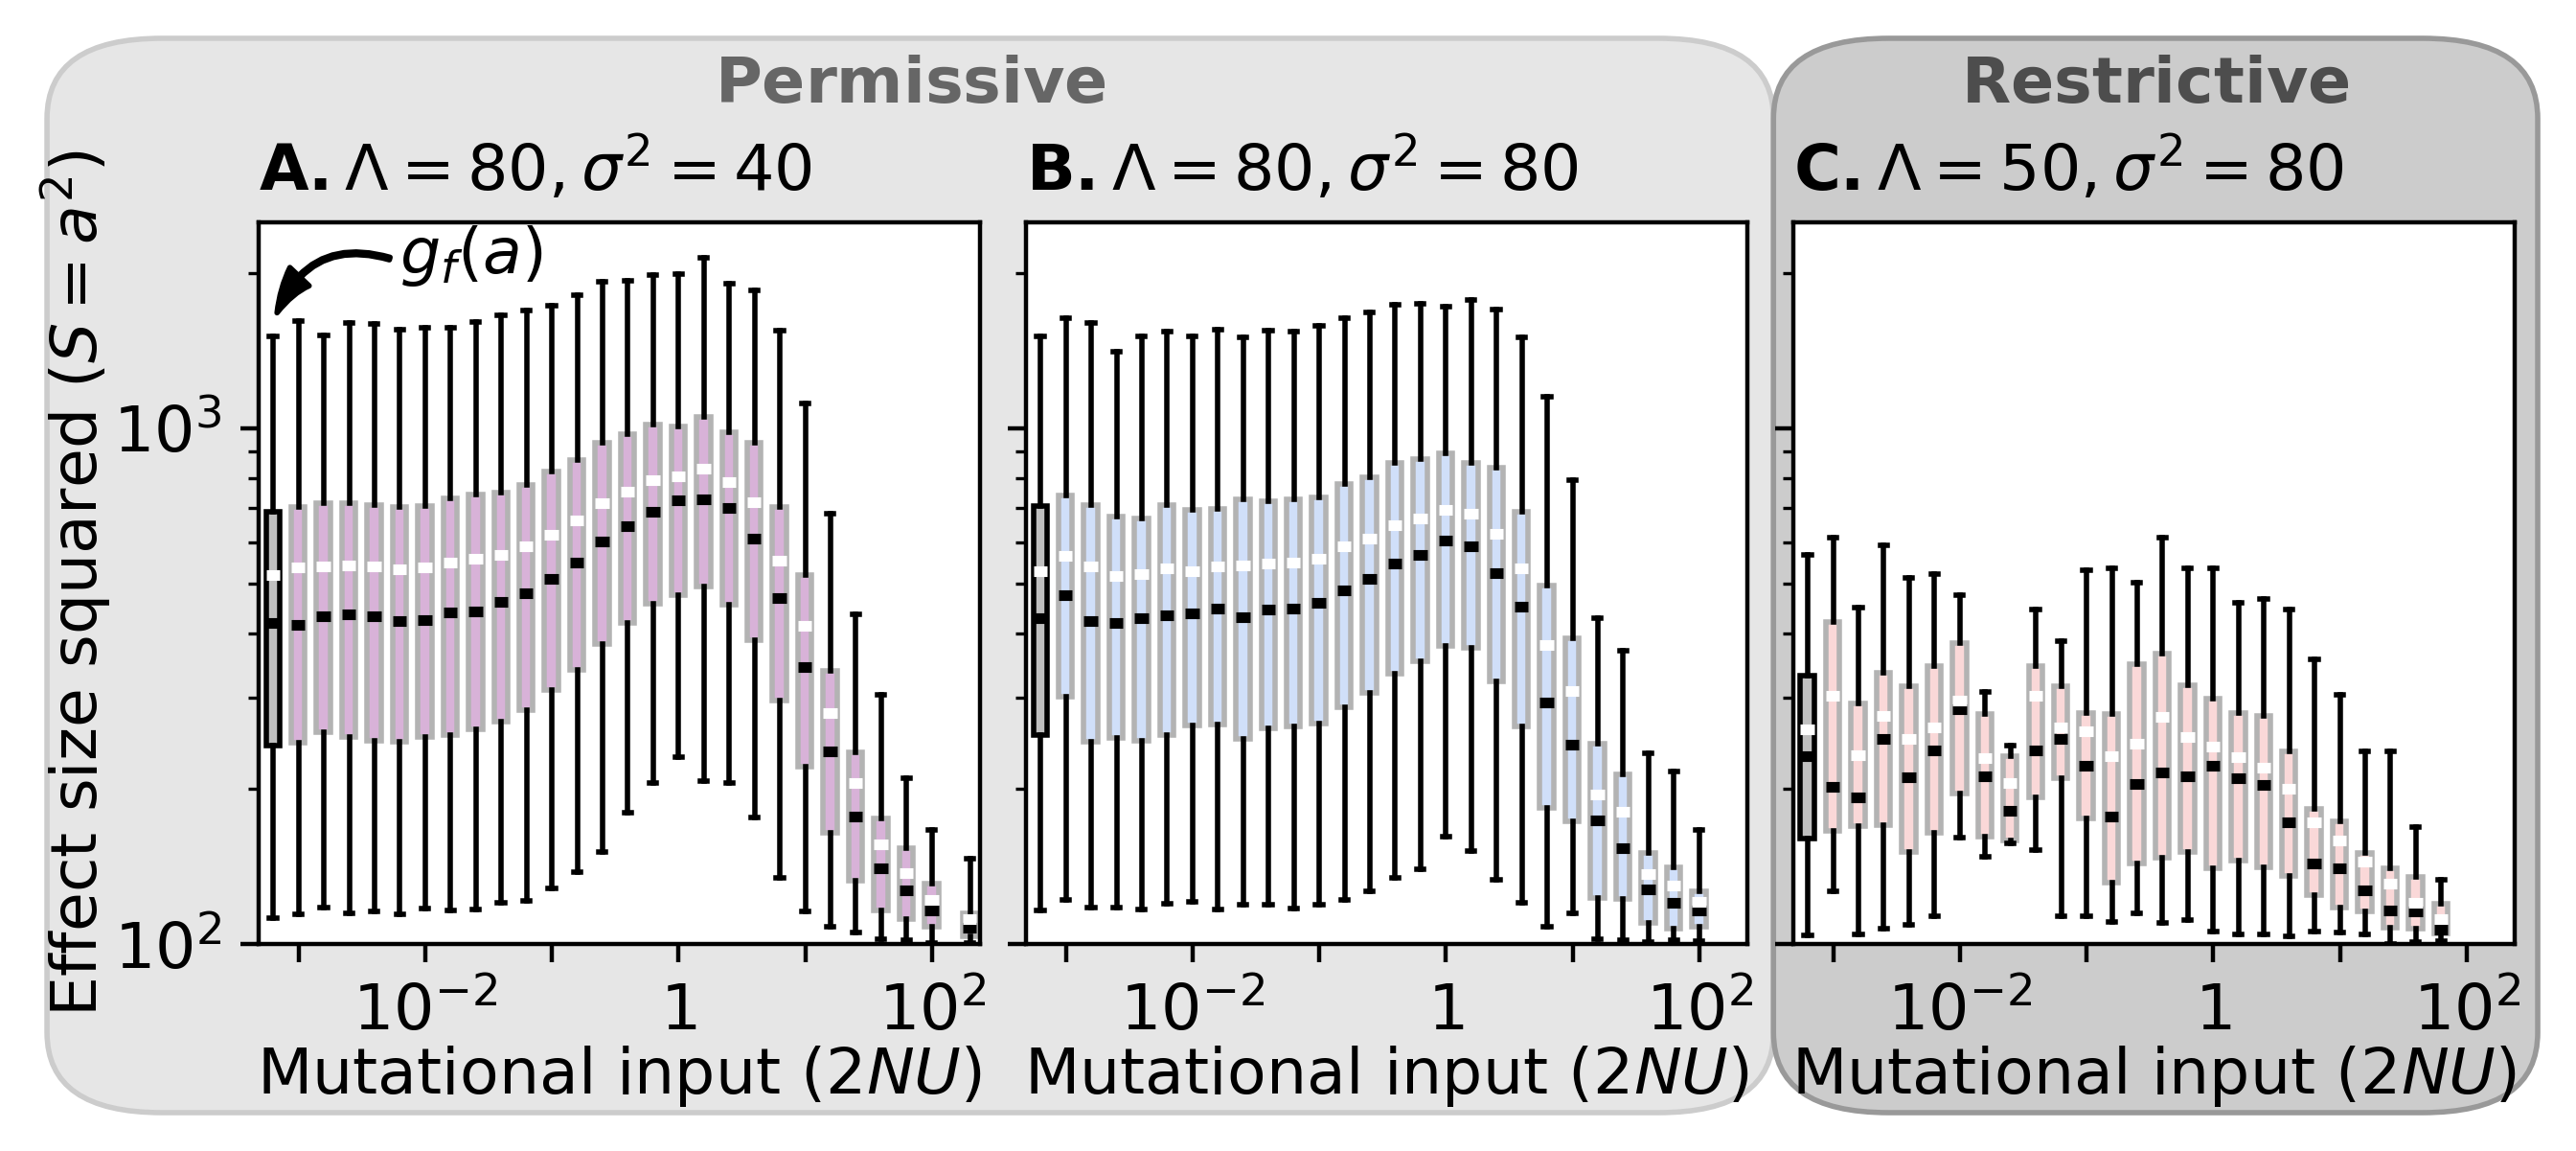

In [8]:

height = 4.366204754776362
cf.make_figure_set_width(fig_function=make_figure_S10,filename='./Figures/Figure_S10.png', target_width_inches=6.5, fig_width=7.3, fig_height=height)

